In [1]:
from yerbamate import env

import os
import pandas as pd

user_aff_path =  os.path.join(env["save"], "hashtags", f"user_hashtag_affiliation.parquet")
label_path = os.path.join(env["save"], "hashtag_propaganda_labeled.csv")
# read CSV file into DataFrame
label_df = pd.read_csv(label_path)
user_aff_df = pd.read_parquet(user_aff_path)

In [6]:
label_df.head()

,hashtag,affiliation,label
0,علاءالسالم,['Shia'],Slogan
1,پایتخت_بصیرت,['Islamic Republic'],Slogan
2,اقتدار_ایران,['Islamic Republic'],Slogan
3,غیرتلی_سردار,['Islamic Republic'],Slogan
4,اربعین_شاهچراغ,['Islamic Republic'],Slogan


In [3]:
user_aff_df.head()

,userId,affiliation,count
0,1930624009,Shia,25
1,408795883,Shia,6
2,143531181,Islamic Republic,47
3,2473674486,Shia,29
4,153841889,Shia,15


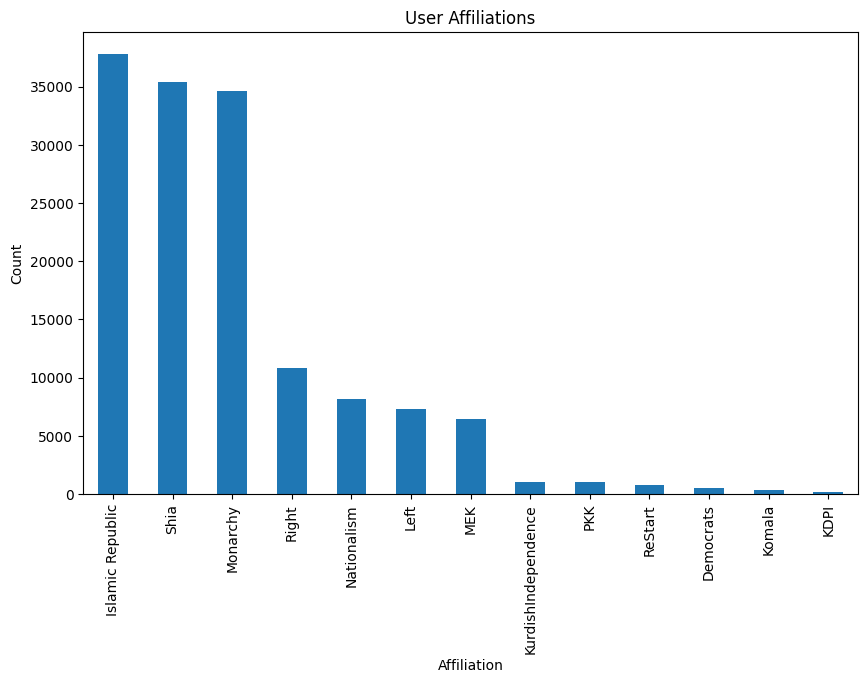

In [8]:
import matplotlib.pyplot as plt

# Get the count of each affiliation
affiliation_counts = user_aff_df['affiliation'].value_counts()

# Generate the plot
plt.figure(figsize=(10,6))
affiliation_counts.plot(kind='bar')
plt.title('User Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Count')
plt.show()


In [10]:
 user_aff_df['affiliation'].unique()

array(['Shia', 'Islamic Republic', 'Left', 'PKK', 'Monarchy', 'MEK',
       'Right', 'Komala', 'ReStart', 'KurdishIndependence', 'Democrats',
       'Nationalism', 'KDPI'], dtype=object)

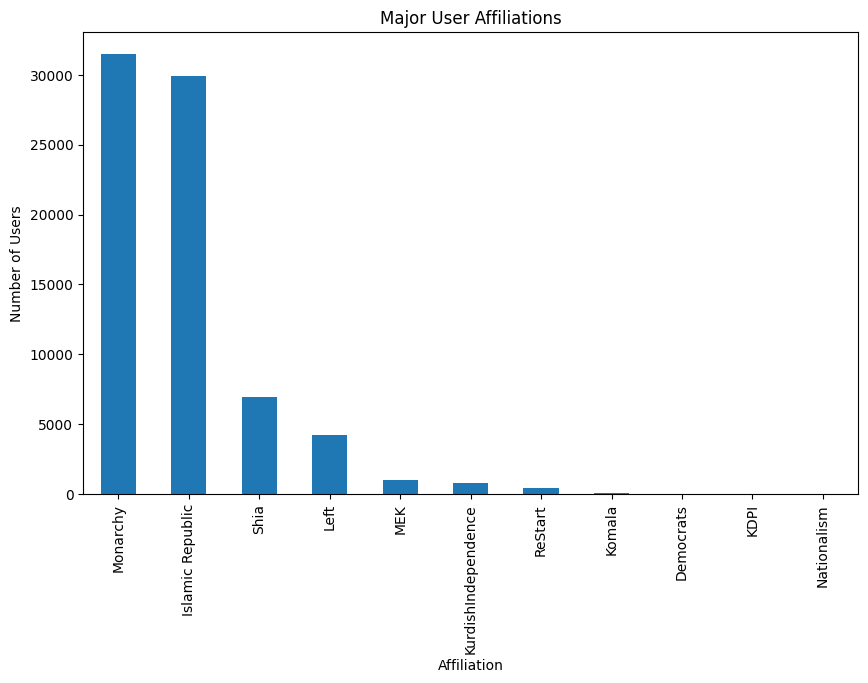

In [30]:
import matplotlib.pyplot as plt

# Group by userId and affiliation, and sum the count
grouped = user_aff_df.groupby(['userId', 'affiliation'])['count'].sum().unstack(fill_value=0)

# Find the major affiliation for each user
grouped['major_affiliation'] = grouped.idxmax(axis=1)

# Count the number of users for each major affiliation
major_affiliation_counts = grouped['major_affiliation'].value_counts()

# Generate the plot
plt.figure(figsize=(10,6))
major_affiliation_counts.plot(kind='bar')
plt.title('Major User Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Number of Users')
plt.show()


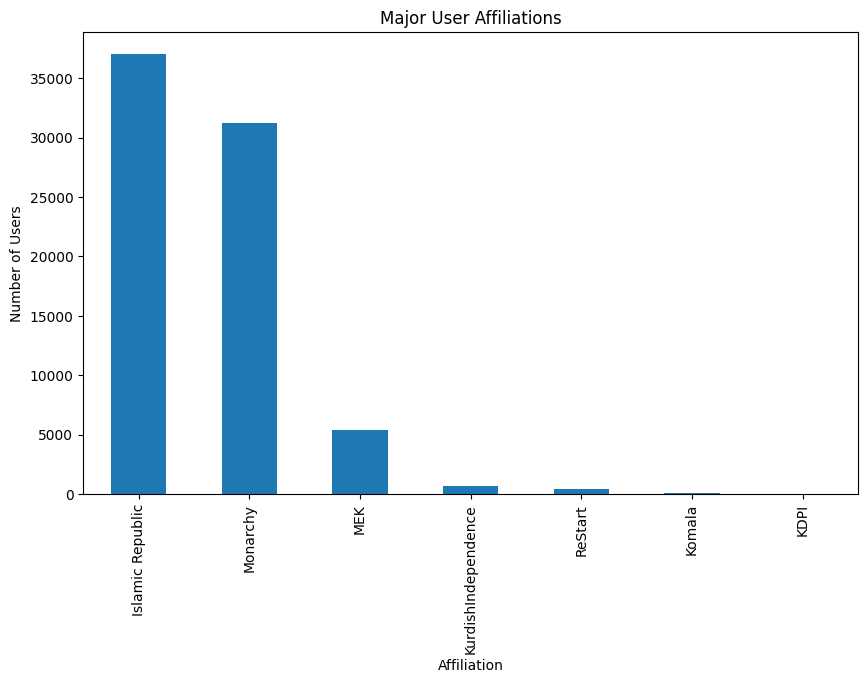

In [27]:
import matplotlib.pyplot as plt

# Define affiliation groupings
affiliation_groupings = {
    'Islamic Republic': ['Islamic Republic', 'Shia'],
    'Monarchy': ['Monarchy', 'Right', 'Nationalism'],
    'MEK': ['Left', 'MEK'],
    'KurdishIndependance': ['KurdishIndependance', 'Left'],
    'ReStart': ['ReStart'],
    'Left': ['Left'],
}

# Apply groupings and aggregate counts# Apply groupings and aggregate counts
grouped = user_aff_df.copy()
grouped['affiliation'] = grouped['affiliation'].apply(
    lambda x: next((group for group, affiliations in affiliation_groupings.items() if x in affiliations), x)
)
grouped = grouped.groupby(['userId', 'affiliation'])['count'].sum().unstack(fill_value=0)

# Find the major affiliation for each user
grouped['major_affiliation'] = grouped.idxmax(axis=1)

# Count the number of users for each major affiliation
major_affiliation_counts = grouped['major_affiliation'].value_counts()

# Generate the plot
plt.figure(figsize=(10,6))
major_affiliation_counts.plot(kind='bar')
plt.title('Major User Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Number of Users')
plt.show()

In [32]:
user_hashtag_path = os.path.join(env["plots"], "analysis", f"user_hashtag_all.parquet")

user_hashtag_df = pd.read_parquet(user_hashtag_path)

user_hashtag_df.head()

,userId,hashtag,count
0,72516079,franceinfo,111
1,72516079,nucleaire,5
2,72516079,VraimentPasDaccord,5
3,72516079,Flers,1
4,72516079,démocratie,7


In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
import os

matplotlib.rcParams["axes.unicode_minus"] = False
from bidi.algorithm import get_display
import arabic_reshaper

# Join user_hashtag_df with grouped to get the major affiliation for each user
user_hashtag_df = user_hashtag_df.set_index('userId')
grouped = grouped.reset_index()
merged = user_hashtag_df.join(grouped[['userId', 'major_affiliation']].set_index('userId'), how='inner')

# Loop over each major affiliation
for affiliation in merged['major_affiliation'].unique():
    # Filter dataframe to get only the rows with the current affiliation
    df_filtered = merged[merged['major_affiliation'] == affiliation]
    
    # Group by hashtag and count
    freq = df_filtered.groupby("hashtag")['count'].sum()
    freq = freq.sort_values(ascending=False)
    freq = freq[:200]  # Top 200 hashtags

    # Generate and show word cloud
    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        background_color="white",
    ).generate_from_frequencies(freq)

    # Save wordcloud
    save_cloud_path = os.path.join(env["plots"], "analysis", "major_affiliation", f"affiliation_{affiliation}.png")

    if not os.path.exists(os.path.dirname(save_cloud_path)):
        os.makedirs(os.path.dirname(save_cloud_path))

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {get_display(arabic_reshaper.reshape(affiliation))}")
    plt.tight_layout()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    plt.show()
    # plt.savefig(save_cloud_path)
